In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from helpers.Classifier import *
import os
import pickle


In [36]:
#Functions
def plot_all_variables(sig_list, bkg_list, xlabels, labels=["sig", "bkg"], name="sig_vs_bkg", title="", outdir="./", *args, **kwargs):
    csig = 'brown'
    cbkg = 'royalblue'
    
    N = len(sig_list)
    
    if N==len(xlabels):
        fig, ax1 = plt.subplots(1, N, figsize=(6*N,5))
        ax1[0].set_ylabel("Events (A.U.)")
        for i in range(N):
            xmin = np.min(np.hstack([bkg_list[i], sig_list[i]]))
            xmax = np.max(np.hstack([bkg_list[i], sig_list[i]]))
            bins = np.linspace(xmin, xmax, 50)
            ax1[i].hist(sig_list[i], bins = bins, density = True, histtype='step', ls= "-", color=csig, label=labels[0])
            ax1[i].hist(bkg_list[i], bins = bins, density = True, histtype='stepfilled', ls= "-", color=cbkg, alpha=0.5, label=labels[1])
            ax1[i].set_xlabel(xlabels[i])
            ax1[i].set_yticks([])
            ax1[i].legend(loc='upper right', fontsize = 9)

        plt.title(title)
        plt.show()
    else:
        print("Wrong input lists!")

In [37]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

do_morph = "reg_mc"
energy = "4TeV"
path_to_working_dir = f"../working_dir"
static_data_dir = f"{path_to_working_dir}/data/"
eval_dir = f"{path_to_working_dir}/evaluation/"

n_context = 2

cuda available: True


### Test Dataset

In [38]:
# load in test events
test_events = np.load(f"{static_data_dir}/test_SR.npz")
test_bkg = test_events["bkg_events_SR"][:,n_context:]
test_sig = test_events["sig_events_SR"][:,n_context:]


input_x_test = np.concatenate([test_bkg, test_sig], axis=0)
input_y_test = np.concatenate([np.zeros(test_bkg.shape[0]).reshape(-1,1), np.ones(test_sig.shape[0]).reshape(-1,1)], axis=0)

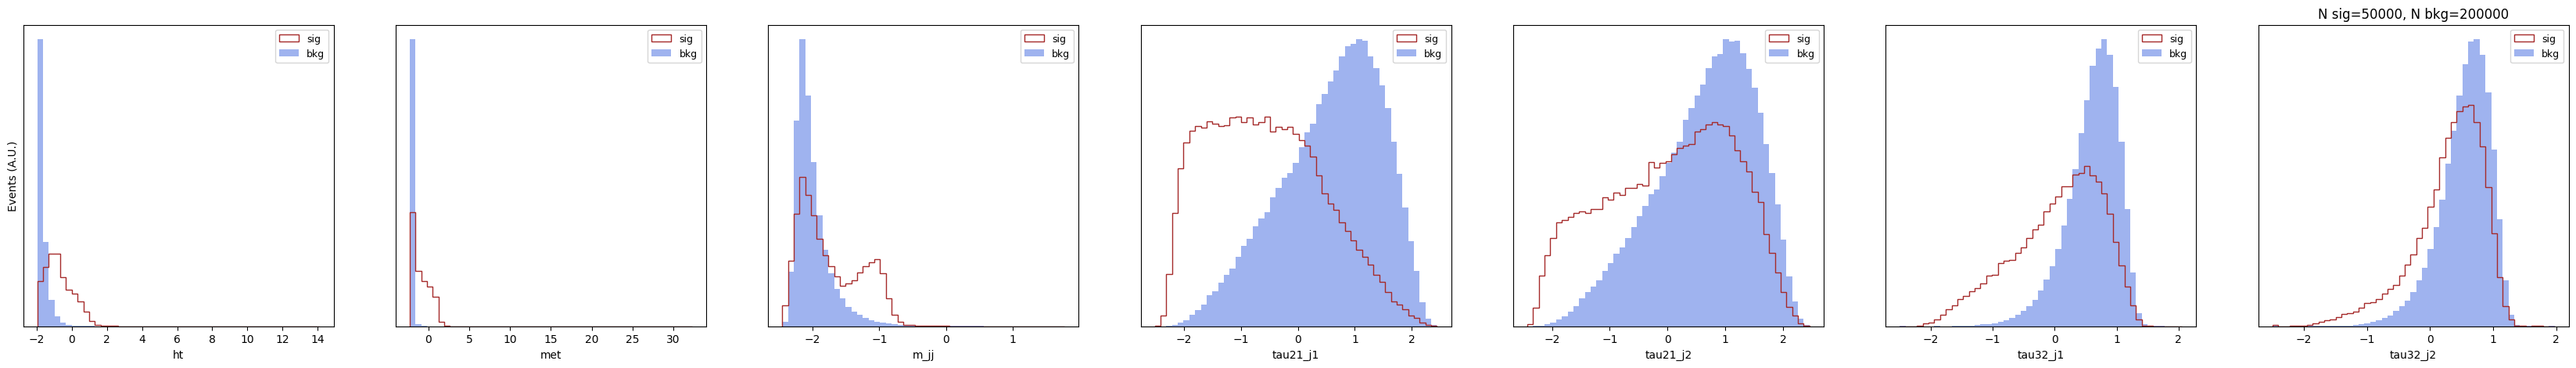

In [40]:
#Plot Test Dataset
sig_list = test_events['sig_events_SR'].T
bkg_list = test_events['bkg_events_SR'].T
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
plot_kwargs = {"labels":["sig", "bkg"], "name":f"sig_vs_bkg_test", "title":f"N sig={len(sig_list[0])}, N bkg={len(bkg_list[0])}"}
plot_all_variables(sig_list, bkg_list, var_names, **plot_kwargs)

### Files to load in

In [4]:
# keys = ["reweight", "generate", "morph", "ideal", "full_sup"]
keys = ["reweight", "generate", "morph"]

signal_injection_seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if energy == "4TeV":
    sig_inj = [0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024]
    sig_inj_labels = [0, 0.0031, 0.0065, 0.0093, 0.0123, 0.0151, 0.0185]
    significances = [0, 0.84, 1.75, 2.52, 3.325, 4.07, 4.99]
# elif energy == "3TeV":
#     sig_inj = [0, 0.004, 0.009, 0.013, 0.018, 0.022, 0.027]
#     sig_inj_labels = [0, 0.0026, 0.0062, 0.0088, 0.0123, 0.0153, 0.0192]
#     significances = [0, 0.72, 1.67, 2.37, 3.31, 4.11, 5.18]
# elif energy == "2TeV":
#     sig_inj = [0, 0.006, 0.012, 0.018, 0.024, 0.03, 0.036]
#     sig_inj_labels = [0, 0.0031, 0.0063, 0.0099, 0.0131, 0.0167, 0.0184]
#     significances = [0, 0.85, 1.70, 2.67, 3.52, 4.50, 4.96]

    
# initialize dirs
rejections_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}                
sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
rocs_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
max_sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
sic_at_rej1_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
sic_at_rej2_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
auc_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}

rejection1_for_sic = 1000
rejection2_for_sic = 10000

x_axis = np.logspace(-5, 0, 100)
x_axis_roc = np.linspace(0, 1, 100)

### Process

In [5]:
reprocess_data = False

In [6]:


if reprocess_data:
    
    for sss, s in enumerate(sig_inj):
    
        s_label = sig_inj_labels[sss]

        print(f"Evaluating s/b = {s}...")
        for k in keys:
            print(f" ---> {k}")
            for data_seed in signal_injection_seeds:
                scores_to_ensemble = []

                # ensemble over runs
                if s == 0 and k != "full_sup":
                    n_classifier_runs = 10
                else:
                    n_classifier_runs = 10

                for i in range(n_classifier_runs):

                    if k == "full_sup": # Only need to train 1 "seed" for the fullup model
                        model_dir = f"{eval_dir}/seed1/"
                        local_id = f"{k}_run{i}"

                    elif s == 0:
                        model_dir = f"{eval_dir}/seed1/"
                        local_id = f"{k}_s0_run{i}"

                    else:
                        model_dir = f"{eval_dir}/seed{data_seed}/"
                        local_id = f"{k}_s{s}_run{i}"

                    # load in the model
                    model_path = f"{model_dir}/model_{local_id}.pt"
                    loc_NN = torch.load(model_path)

                    scores = loc_NN.evaluation(input_x_test)
                    scores_to_ensemble.append(scores)


                avg_scores = np.mean(scores_to_ensemble, axis = 0)
                fpr, tpr, _ = roc_curve(input_y_test, avg_scores)

                fpr_nonzero_indices = np.where(fpr != 0)
                fpr_nonzero = fpr[fpr_nonzero_indices]
                tpr_nonzero = tpr[fpr_nonzero_indices]
                rejection = 1.0 / fpr_nonzero 
                sic = tpr_nonzero / np.sqrt(fpr_nonzero) 

                # calculate the maxsic
                eps_bkg = 1.0/((0.4**2)*(test_bkg.shape[0]))
                fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)
                maxsic = np.nanmax(sic[fpr_cutoff_indices])

                # calculate the sic at the desired rejection rejection_for_sic
                for ind in range(len(rejection)):
                    if (rejection[ind] >= rejection1_for_sic) and (rejection[ind+1] < rejection1_for_sic):
                        sic_at_rejection1 = sic[ind]
                    if (rejection[ind] >= rejection2_for_sic) and (rejection[ind+1] < rejection2_for_sic):
                        sic_at_rejection2 = sic[ind]

                interp_sic = np.interp(x_axis, tpr_nonzero, sic)
                interp_rej = np.interp(x_axis, tpr_nonzero, rejection)
                interp_roc = np.interp(x_axis_roc, fpr, tpr)

                rejections_dict[k][s_label].append(interp_rej)
                sics_dict[k][s_label].append(interp_sic)
                rocs_dict[k][s_label].append(interp_roc)

                max_sics_dict[k][s_label].append(maxsic)
                sic_at_rej1_dict[k][s_label].append(sic_at_rejection1)
                sic_at_rej2_dict[k][s_label].append(sic_at_rejection2)

    print("Done!")

In [7]:
# Save out data

if reprocess_data:

    pickle.dump( rejections_dict, open( f"pickles/rejections_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( sics_dict, open( f"pickles/sics_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( rocs_dict, open( f"pickles/rocs_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( max_sics_dict, open( f"pickles/max_sics_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( sic_at_rej1_dict, open( f"pickles/sic_at_rej1_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( sic_at_rej2_dict, open( f"pickles/sic_at_rej2_dict_{do_morph}_{energy}.p", "wb" ) )
    pickle.dump( auc_dict, open( f"pickles/auc_dict_{do_morph}_{energy}.p", "wb" ) )


In [8]:
# Load in data

rejections_dict = pickle.load(open( f"pickles/rejections_dict_{do_morph}_{energy}.p", "rb" ) )
sics_dict = pickle.load(open( f"pickles/sics_dict_{do_morph}_{energy}.p", "rb" ) )
rocs_dict = pickle.load(open( f"pickles/rocs_dict_{do_morph}_{energy}.p", "rb" ) )
max_sics_dict = pickle.load(open( f"pickles/max_sics_dict_{do_morph}_{energy}.p", "rb" ) )
sic_at_rej1_dict = pickle.load(open( f"pickles/sic_at_rej1_dict_{do_morph}_{energy}.p", "rb" ) )
sic_at_rej2_dict = pickle.load(open( f"pickles/sic_at_rej2_dict_{do_morph}_{energy}.p", "rb" ) )
auc_dict = pickle.load(open( f"pickles/auc_dict_{do_morph}_{energy}.p", "rb" ) )



In [9]:
def get_med_percentile(loc_list, lower_p = 16, upper_p = 84):
    
    med = np.nanmedian(loc_list, axis = 0)
    lower_p  = np.nanpercentile(loc_list, lower_p, axis = 0)
    upper_p = np.nanpercentile(loc_list, upper_p, axis = 0)
    
    return med, lower_p, upper_p

In [10]:
# ss = 0
# kk = "generate"

# plt.figure()
# for i in range(0, 8):
#     plt.plot(x_axis, sics_dict[kk][ss][i], label = i+1)
# plt.legend()
# plt.show()

# plt.figure()
# for i in range(0, 8):
#     plt.plot(x_axis, rejections_dict[kk][ss][i], label = i+1)
# plt.legend()
# plt.yscale("log")
# plt.show()


# plt.figure()
# for i in range(0, 8):
#     plt.plot(x_axis, rocs_dict[kk][ss][i], label = i+1)
# plt.legend()
# plt.show()

In [11]:
# Take medians
med_rejections_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_rocs_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_max_sics_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys} # mean, lower_p, upper_p
med_sics_at_rej1_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}
med_sics_at_rej2_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}

for s in sig_inj_labels:
    
    for k in keys:

        med_rejections_dict[k][s] = get_med_percentile(rejections_dict[k][s])
        med_sics_dict[k][s] = get_med_percentile(sics_dict[k][s])
        med_rocs_dict[k][s] = get_med_percentile(rocs_dict[k][s])
                 
        # max sic sic at rejection are single numbers, not arrays
        med_max_sics_dict[k][0] = np.append(med_max_sics_dict[k][0], np.median(max_sics_dict[k][s]))
        med_max_sics_dict[k][1] = np.append(med_max_sics_dict[k][1], np.percentile(max_sics_dict[k][s], 16)) 
        med_max_sics_dict[k][2] = np.append(med_max_sics_dict[k][2], np.percentile(max_sics_dict[k][s], 84))        
            
        med_sics_at_rej1_dict[k][0] = np.append(med_sics_at_rej1_dict[k][0], np.median(sic_at_rej1_dict[k][s]))
        med_sics_at_rej1_dict[k][1] = np.append(med_sics_at_rej1_dict[k][1], np.percentile(sic_at_rej1_dict[k][s], 16))
        med_sics_at_rej1_dict[k][2] = np.append(med_sics_at_rej1_dict[k][2], np.percentile(sic_at_rej1_dict[k][s], 84))
        
        med_sics_at_rej2_dict[k][0] = np.append(med_sics_at_rej2_dict[k][0], np.median(sic_at_rej2_dict[k][s]))
        med_sics_at_rej2_dict[k][1] = np.append(med_sics_at_rej2_dict[k][1], np.percentile(sic_at_rej2_dict[k][s], 16))
        med_sics_at_rej2_dict[k][2] = np.append(med_sics_at_rej2_dict[k][2], np.percentile(sic_at_rej2_dict[k][s], 84))
      

## Summary plots

In [12]:
# Plotting params

# colors_dict = {"full_sup":"grey",
#                "reweight": "forestgreen",
#                "morph": "mediumvioletred",
#                "generate":"darkgoldenrod",
#                 "ideal":"darkblue"}
colors_dict = {"reweight": "forestgreen",
               "morph": "mediumvioletred",
               "generate":"darkgoldenrod"}


labels_dict = {"reweight": "Reweight",
               "morph": "Morph",
               "generate":"Generate"}


l = 3
f1 = 24
f2 = 16

alpha = 0.4

### Plot max(SIC)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21416/4091648924.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)


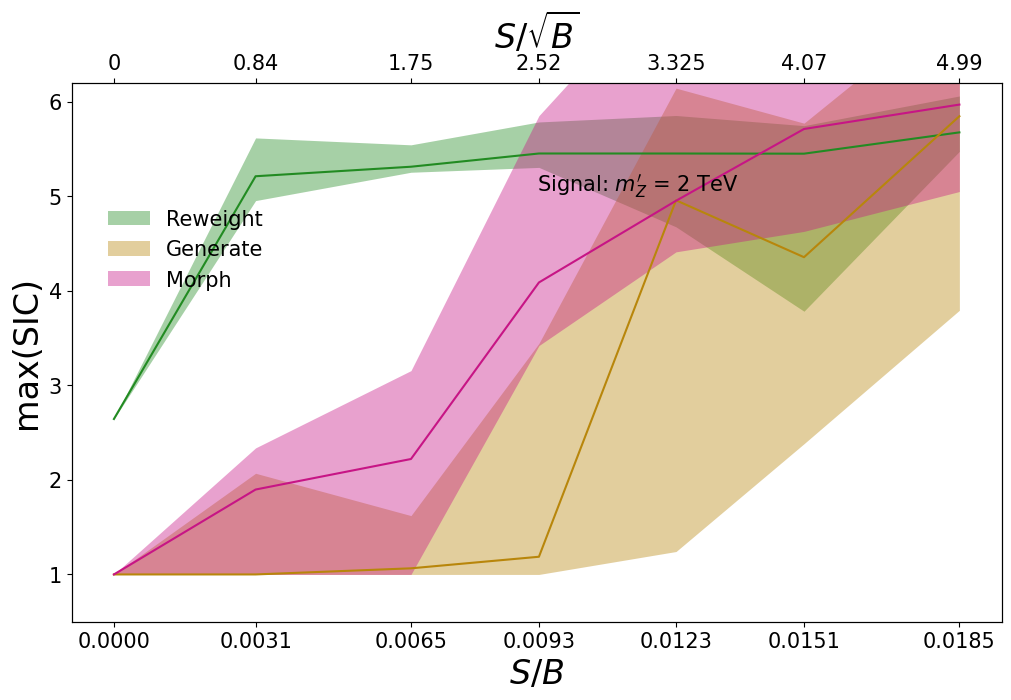

In [13]:
f1 = 24
f2 = 15


fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:  
    ax1.plot(sig_inj_labels, med_max_sics_dict[k][0], color = colors_dict[k])   
    ax1.fill_between(sig_inj_labels, med_max_sics_dict[k][1],
                        med_max_sics_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = (.03,.6))
ax1.set_ylabel("max(SIC)", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

#plt.ylim(0,21)
plt.ylim(0.5, 6.2)
plt.text(0.5, 0.8, "Signal: $m_Z'$ = 2 TeV", fontsize=f2, transform=plt.gca().transAxes)
fig.savefig(f"plots/maxsic_{do_morph}_{energy}.pdf")

plt.show()

### Plot SIC at a rejection of 10^3

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21416/2716297494.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)


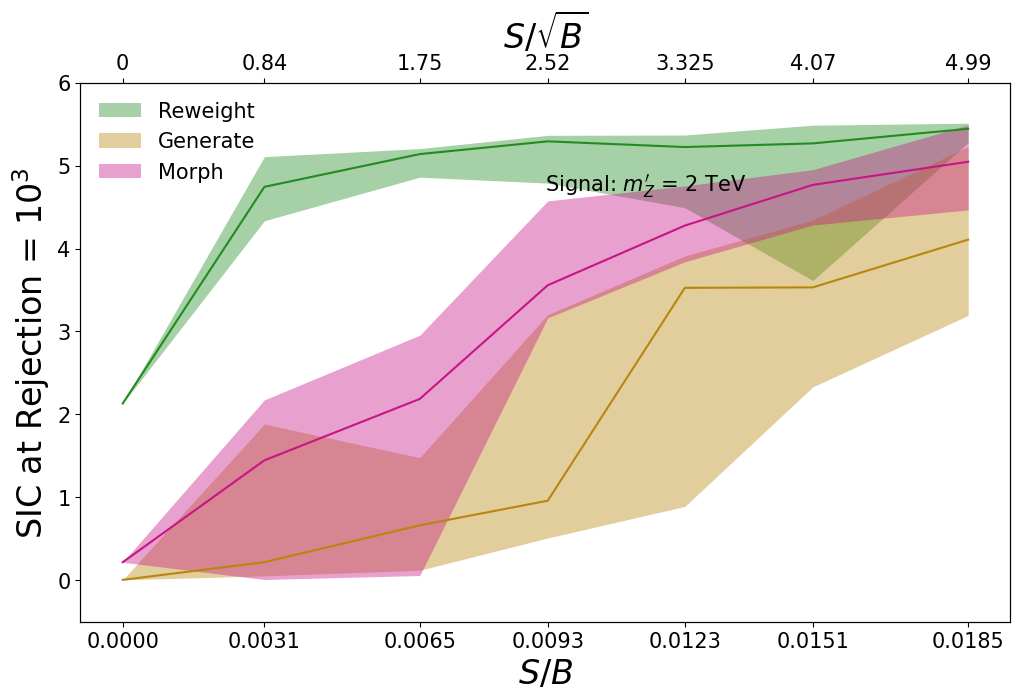

In [14]:

fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:    
   
    ax1.plot(sig_inj_labels, med_sics_at_rej1_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj_labels, med_sics_at_rej1_dict[k][1],
                        med_sics_at_rej1_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^3$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)
#plt.ylim(0,8.8)
plt.ylim(-0.5,6)
plt.text(0.5, 0.8, "Signal: $m_Z'$ = 2 TeV", fontsize=f2, transform=plt.gca().transAxes)

fig.savefig(f"plots/sic_at_rej_1000_{do_morph}_{energy}.pdf")

plt.show()

### Plot SIC at a rejection of 10^4

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21416/896944995.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)


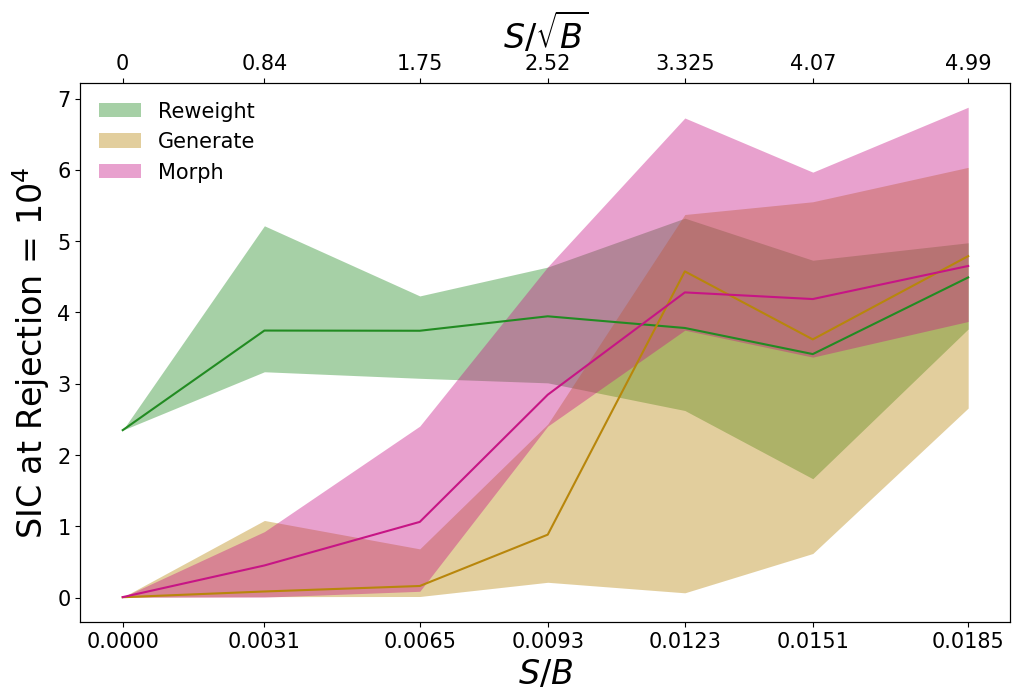

In [15]:

fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:
    
    ax1.plot(sig_inj_labels, med_sics_at_rej2_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj_labels, med_sics_at_rej2_dict[k][1],
                        med_sics_at_rej2_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^4$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

fig.savefig(f"plots/sic_at_rej_10000_{do_morph}_{energy}.pdf")



## Fixed S/B plots

### Plot SIC 

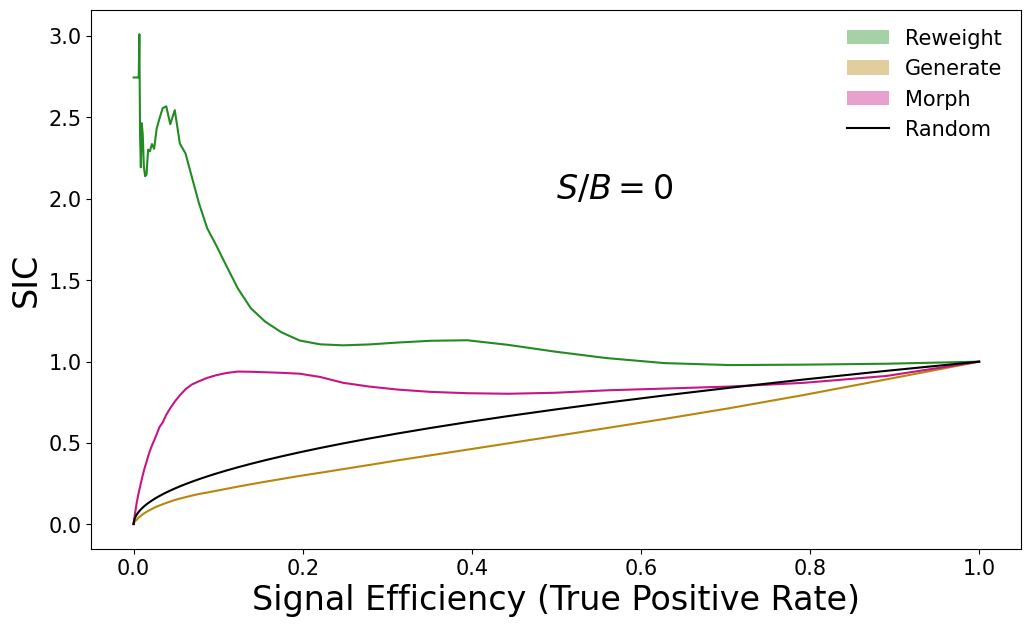

In [30]:
n_to_plot = [0]


for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        if k != "full_sup":
        
            plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k])
            plt.fill_between(x_axis, med_sics_dict[k][n][1],
                        med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
        

    plt.text(0.5, 2, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f1)    
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    fig.savefig(f"plots/sic_0.pdf")    
    plt.show()

### Plot SIC vs rejection

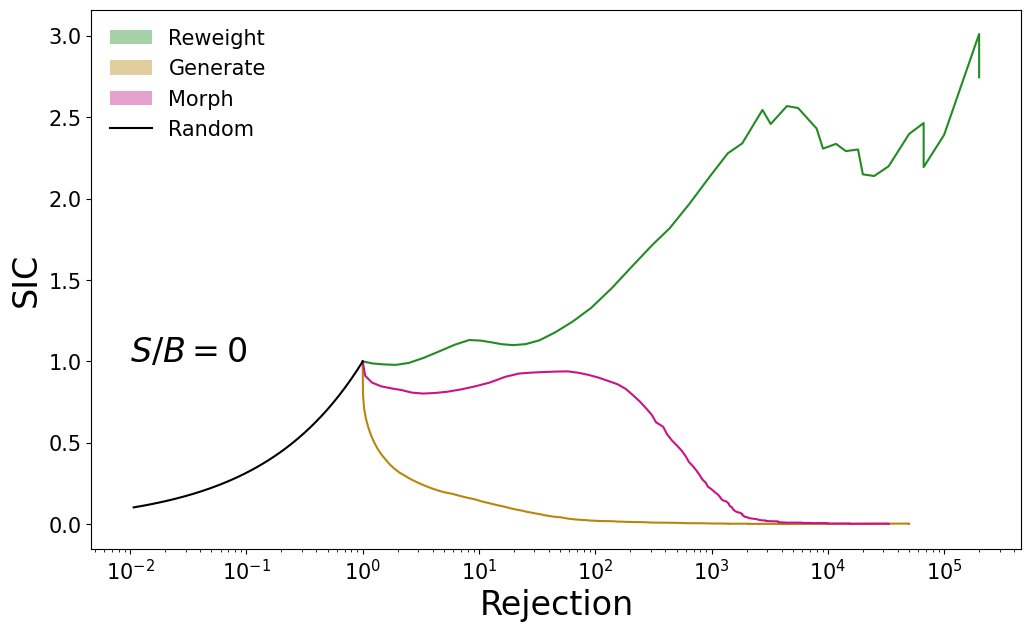

In [31]:
for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis[60:], x_axis[60:]/np.sqrt(x_axis[60:]), label = "Random", color = "black",)
    
    plt.xscale("log")    
    plt.text(0.01, 1, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False,)
    plt.xlabel("Rejection", fontsize = f1)
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize = f2)
        
    plt.show()

### Plot ROCs

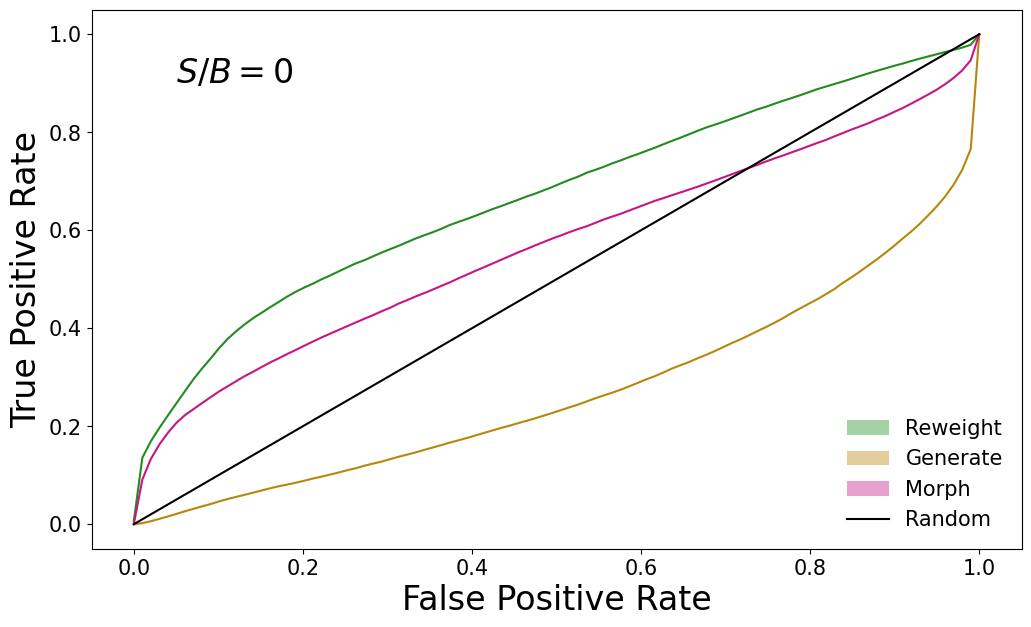

In [32]:
n_to_plot = [0]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:

        plt.plot(x_axis_roc, med_rocs_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(x_axis_roc, med_rocs_dict[k][n][1],
                    med_rocs_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis_roc, x_axis_roc, label = "Random", color = "black",)

    plt.text(0.05, 0.9, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("False Positive Rate", fontsize = f1)    
    plt.ylabel("True Positive Rate", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    
    plt.show()

In [34]:
# take avg over classifier runs for 0 signal injection
    
# initialize dirs
sics_classif_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
rocs_classif_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}

for k in keys:
    print(f" ---> {k}")
    for data_seed in signal_injection_seeds:
        scores_to_ensemble = []

        # ensemble over runs
        n_classifier_runs = 10

        for i in range(n_classifier_runs):

            if k == "full_sup": # Only need to train 1 "seed" for the fullup model
                model_dir = f"{eval_dir}/seed1/"
                local_id = f"{k}_run{i}"

            else:
                model_dir = f"{eval_dir}/seed1/"
                local_id = f"{k}_s0_run{i}"

            # load in the model
            model_path = f"{model_dir}/model_{local_id}.pt"
            loc_NN = torch.load(model_path)

            scores = loc_NN.evaluation(input_x_test)
            scores_to_ensemble.append(scores)

            fpr, tpr, _ = roc_curve(input_y_test, scores)

            fpr_nonzero_indices = np.where(fpr != 0)
            fpr_nonzero = fpr[fpr_nonzero_indices]
            tpr_nonzero = tpr[fpr_nonzero_indices]
            rejection = 1.0 / fpr_nonzero 
            sic = tpr_nonzero / np.sqrt(fpr_nonzero) 

            # calculate the maxsic
            eps_bkg = 1.0/((0.4**2)*(72000))
            fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)

            interp_sic = np.interp(x_axis, tpr_nonzero, sic)
            interp_roc = np.interp(x_axis_roc, fpr, tpr)

            sics_classif_dict[k][0].append(interp_sic)
            rocs_classif_dict[k][0].append(interp_roc)


print("Done!")


 ---> reweight


/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

 ---> generate


/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

 ---> morph


/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc_NN = torch.load(model_path)
/tmp/ipykernel_5128/1460643419.py:27: FutureWarning: You 

Done!


In [35]:

# Take medians
med_classif_sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_classif_rocs_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}

for s in [0]:
    
    for k in keys:

        med_classif_sics_dict[k][s] = get_med_percentile(sics_classif_dict[k][s])
        med_classif_rocs_dict[k][s] = get_med_percentile(rocs_classif_dict[k][s])
                 


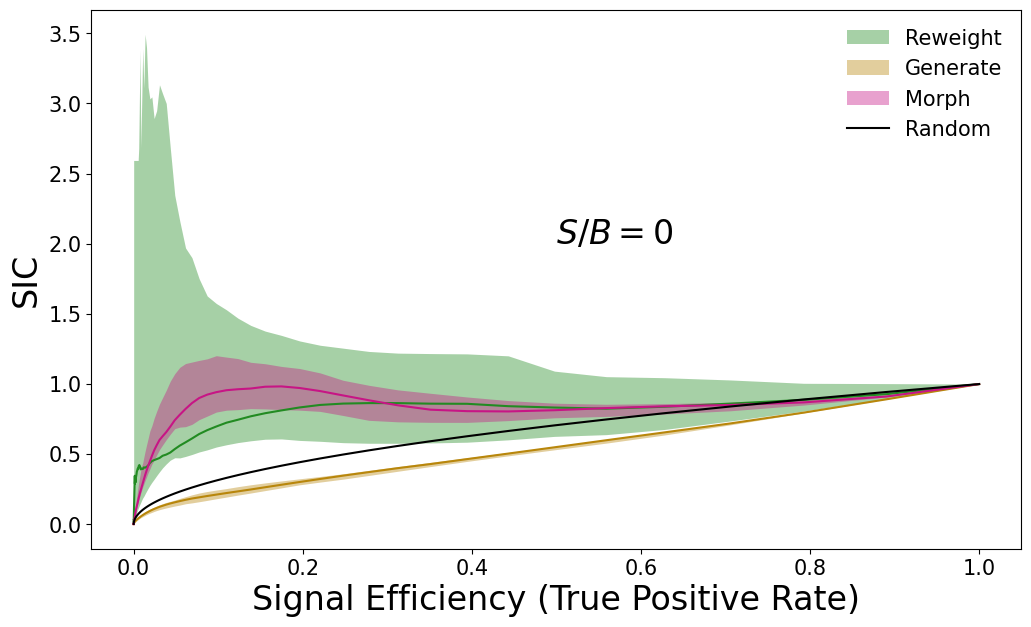

In [36]:
n_to_plot = [0]


for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        if k != "full_sup":
        
            plt.plot(x_axis, med_classif_sics_dict[k][n][0], color = colors_dict[k])
            plt.fill_between(x_axis, med_classif_sics_dict[k][n][1],
                        med_classif_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
        

    plt.text(0.5, 2, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f1)    
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    fig.savefig(f"plots/sic_0.pdf")    
    plt.show()

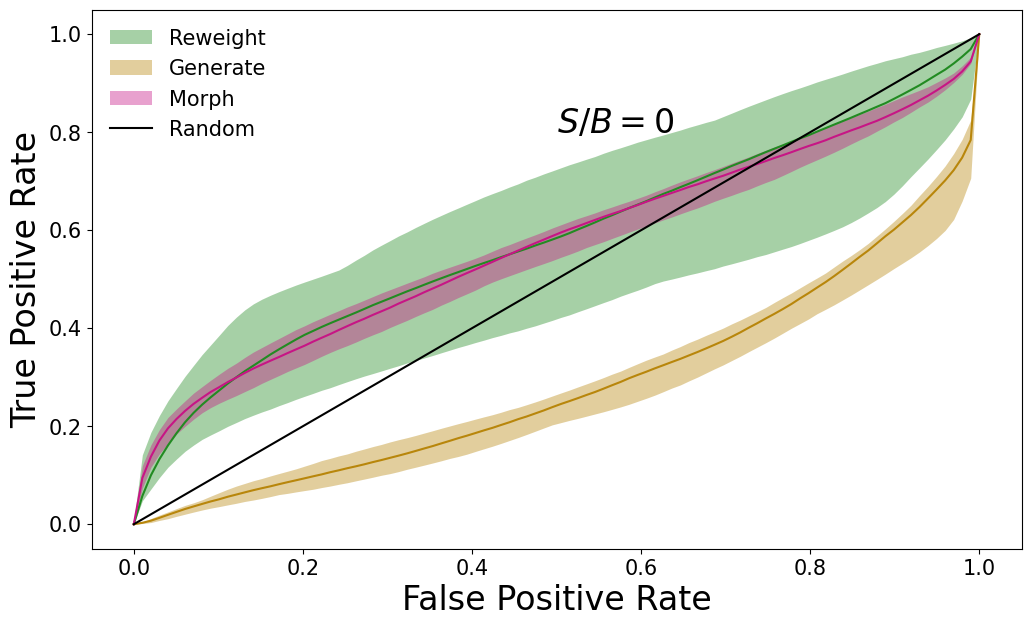

In [37]:
n_to_plot = [0]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        
        if k != "full_sup":

            plt.plot(x_axis_roc, med_classif_rocs_dict[k][n][0], color = colors_dict[k])

            plt.fill_between(x_axis_roc, med_classif_rocs_dict[k][n][1],
                        med_classif_rocs_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis_roc, x_axis_roc, label = "Random", color = "black",)

    plt.text(0.5, 0.8, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("False Positive Rate", fontsize = f1)    
    plt.ylabel("True Positive Rate", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    fig.savefig(f"plots/roc_0.pdf")  
    plt.show()